# Processing Hanna 2020

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes in AACC03

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

from core import add_transform_col

In [2]:
aacc03_reads = pd.read_csv('../data/raw/Hanna2020_aacc03_be39_reads.csv')
aacc03_annotations = pd.read_csv('../data/raw/Hanna2020_aacc03_annotations.csv')
aacc03_tp_genes = ['EEF2', 'HNRNPU', 'PELP1', 'TFRC', 'SF3B1', 'PSMA6', 'KPNB1', 'SNRPD1', 'RPS20', 'POLR1C']
aacc03_fp_genes = ['CD81', 'CD33', 'FAS', 'ICAM1']

## AACC03

In [8]:
aacc03_read_cols = ['pDNA', 'A375_Dropout_RepA', 'A375_Dropout_RepB',
                    'MELJUSO_Dropout_RepA', 'MELJUSO_Dropout_RepB',
                    'OVCAR8_Dropout_RepA', 'OVCAR8_Dropout_RepB',
                    'HA1E_Dropout_RepA', 'HA1E_Dropout_RepB',
                    'HAP1_Dropout_RepA', 'HAP1_Dropout_RepB']
aacc03_lognorms = pool.lognorm_columns(reads_df=aacc03_reads.drop(['A375_Vemurafenib_RepA',
                                                                   'A375_Vemurafenib_RepB'], axis=1),
                                       columns=aacc03_read_cols)
aacc03_filtered_lognorms = pool.filter_pdna(lognorm_df=aacc03_lognorms, pdna_cols=['pDNA'], z_low=-3)
print('pDNA Filtered: ' + str(aacc03_lognorms.shape[0] - aacc03_filtered_lognorms.shape[0]))

pDNA Filtered: 70


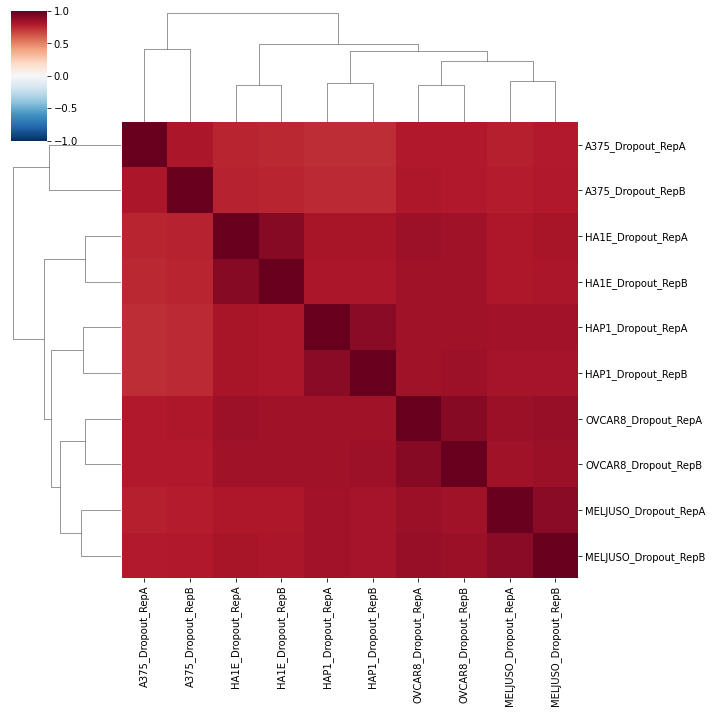

In [9]:
aacc03_read_cols.remove('pDNA')
aacc03_lfc_df = pool.calculate_lfcs(lognorm_df=aacc03_filtered_lognorms, ref_col='pDNA',
                                    target_cols=aacc03_read_cols)
aacc03_cors = aacc03_lfc_df.corr()
sns.clustermap(aacc03_cors, cmap='RdBu_r', vmin=-1, vmax=1)

In [10]:
aacc03_long_cors = (aacc03_cors.reset_index()
                    .rename({'index': 'condition_rep1'}, axis=1)
                    .melt(id_vars='condition_rep1',
                          var_name='condition_rep2', value_name='r'))
aacc03_long_cors[['condition1', 'rep1']] = aacc03_long_cors['condition_rep1'].str.split('_', expand=True)[[0, 2]]
aacc03_long_cors[['condition2', 'rep2']] = aacc03_long_cors['condition_rep2'].str.split('_', expand=True)[[0, 2]]
filtered_cors = aacc03_long_cors[(aacc03_long_cors['condition1'] == aacc03_long_cors['condition2']) &
                          (aacc03_long_cors['rep1'] != aacc03_long_cors['rep2'])]
mean_pearson = filtered_cors['r'].mean()
print('Mean correlation: ' + str(round(mean_pearson, 4)))

Mean correlation: 0.8872


In [16]:
aacc03_sg_list = list(aacc03_lfc_df['sgRNA sequence'].unique())
aacc03_design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                                   filters=[[('sgRNA Sequence', 'in', aacc03_sg_list)]])

In [ ]:
aacc03_avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=aacc03_lfc_df, guide_col='sgRNA sequence',
                                                          condition_indices=[0], sep='_')

In [15]:
aacc03_lfcs_designs = (aacc03_avg_replicate_lfc_df
                       .merge(aacc03_annotations, how = 'inner', on = 'sgRNA sequence')
                       .rename({'sgRNA sequence': 'sgRNA Sequence',
                                'Gene symbol': 'Target Gene Symbol',
                                'Ensembl transcript ID': 'Target Transcript'}, axis=1))
roc_aucs, _ = pool.get_roc_aucs(lfcs=aacc03_lfcs_designs[(aacc03_lfcs_designs['Mutation category'].str
                                                          .contains('Missense|Nonsense', na=False))],
                                tp_genes=aacc03_tp_genes,
                                fp_genes=aacc03_fp_genes, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs

KeyError: 'Target Gene Symbol'

In [ ]:
roc_aucs['ROC-AUC'].mean()

In [ ]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(tp_genes)]
filtered_sgs = relevant_sgs_designs[(relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(relevant_sgs_designs.shape[0] - filtered_sgs.shape[0]))

In [ ]:
filtered_sgs['neg_lfc'] = -filtered_sgs['avg_lfc']
filtered_sgs = add_transform_col(df=filtered_sgs,
                                 col='neg_lfc',
                                 transform_name='yeo-johnson',
                                 transformed_name='scaled_neg_lfc',
                                 group_col=['Target Gene Symbol', 'condition'])
sg_avg_score = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                     'Target Cut %', 'On-Target Efficacy Score'])
                .agg({'scaled_neg_lfc': 'mean'})
                .reset_index())
sg_avg_score['scaled_neg_lfc'] = ((sg_avg_score['scaled_neg_lfc'] - sg_avg_score['scaled_neg_lfc'].mean())/
                                  sg_avg_score['scaled_neg_lfc'].std())

In [ ]:
training_data = sg_avg_score.drop('On-Target Efficacy Score', axis=1)
training_data

In [ ]:
training_data.to_csv('../data/processed/DeWeirdt2020_activity.csv', index=False)